# A Machine learning problem: reduced order modelling and video prediction
Data: 48 videos are available, describing the evolution of a physical field with different initial conditions. Each video is of dimension 128 * 128 * 16 (timesteps) with binary pixel values. For all the tasks please use the first 40 videos as training (including validation) data and the rest 8 as test data

##### Q1 Perform the Principle component analysis of the training dataset where each snapshot (i.e., image) is considered as a sample. Use the principle component for data compressing and decompressing.

1. Convert mp4 to frame png files
2. Perform PCA to compress data



##### Step 1: Import libraries and visualise data

In [2]:
import cv2
import os
from sklearn.decomposition import PCA 
import numpy as np 
import imageio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


In [3]:
videos = np.zeros((49, 16, 128, 128))


for i in range(49):
    path = 'data/video_' + str(i)
    
    if not os.path.exists(path):
        os.mkdir(path)
    else:
        print("Folder already exists")

    vid = cv2.VideoCapture('videos/fire_Chimney_video_' + str(i) + '.mp4')
    print(int(vid.get(cv2.CAP_PROP_FRAME_COUNT)))


    frames = np.zeros((16, 128, 128))

    currentframe = 0

    for j in range(16):

        ret, frame = vid.read()

        if ret == False:
            vid.release()
            print(str(j) + " fail")
            break


        else:
            name = 'data/video_' + str(i) + '/' + str(j) +  ".png"
            g_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(name, g_frame)
            frames[j,:,:] = np.array(g_frame)


            print(str(j) + " success")

        cv2.destroyAllWindows()

    videos[i,:,:,:] = frames


print(videos.shape)


Folder already exists
16
0 success
1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
10 success
11 success
12 success
13 success
14 success
15 success
Folder already exists
16
0 success
1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
10 success
11 success
12 success
13 success
14 success
15 success
Folder already exists
16
0 success
1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
10 success
11 success
12 success
13 success
14 success
15 success
Folder already exists
16
0 success
1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
10 success
11 success
12 success
13 success
14 success
15 success
Folder already exists
16
0 success
1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
10 success
11 success
12 success
13 success
14 success
15 success
Folder already exists
16
0 success
1 success


#### Video 1 pre-PCA

(16, 128, 128)


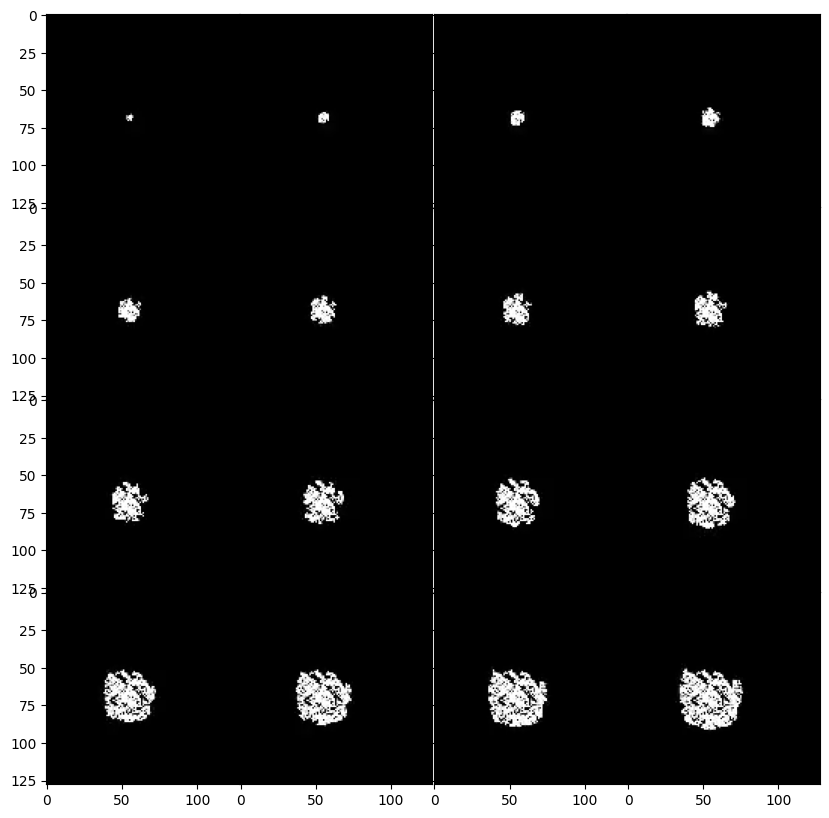

In [4]:
video_0 = videos[0,:,:,:]

video_0.reshape((128, 128, 16))
print(video_0.shape)

def display_frames(video):
    fig, axs = plt.subplots(4, 4, sharey = True, sharex = True, figsize = (10,10))
    fig.subplots_adjust(wspace = 0, hspace = 0)


    for i in range(4):
        axs[i][0].imshow((video[(4*i),:,:]), cmap = 'grey')
        axs[i][1].imshow((video[4*(i)+1,:,:]), cmap = 'grey')
        axs[i][2].imshow((video[4*(i)+2,:,:]), cmap = 'grey')
        axs[i][3].imshow((video[4*(i)+3,:,:]), cmap = 'grey')
        
display_frames(video_0)

#### PCA on video 1

(16, 16384)
(16, 8)
(16, 128, 128)
0.0


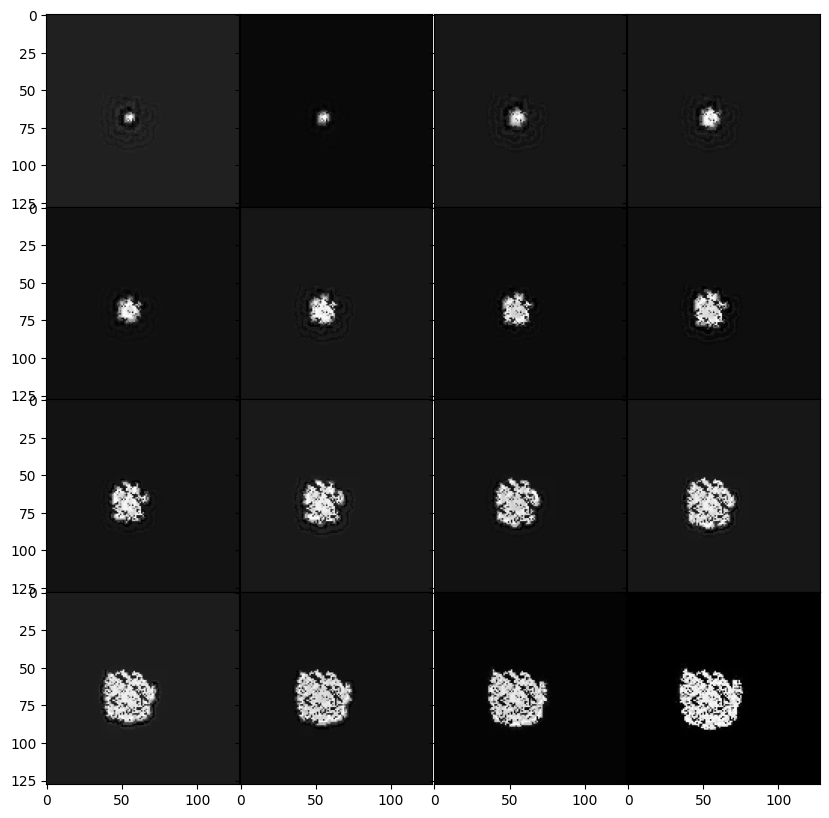

In [5]:
def vid_pca(video, n_components = 16):
    no_frames, height, width = video.shape
    vid_matrix = video.reshape(no_frames,-1)

    print(vid_matrix.shape)


    pca = PCA(n_components= n_components)
    comp = pca.fit_transform(vid_matrix)

    print(comp.shape)

    decomp = pca.inverse_transform(comp)
    decomp = decomp.reshape(no_frames, height, width)

    print(decomp.shape)

    return decomp

vid_0 = vid_pca(video_0, 8)

display_frames(vid_0)

print(video_0[15, 1, 1])



#### TODO:
-	For a random video in the dataset: display the frames before PCA, PCA with 1,4,8,12 and 16 components
- Image compression using convolutional autoencoder
- perform thresholding for binary pixel values

In [5]:
print(torch.__version__)

2.2.1+cu118


In [35]:
class CAE(nn.Module):
    def __init__(self, orig_dim, batch_size):
        super(CAE, self).__init__()
        
        n = 4
        flat_size =  torch.numel(orig_dim)*2
        

        self.conv1 = nn.Sequential(
            
            nn.Conv3d(1 ,n, kernel_size= 3, padding =1), 
            nn.BatchNorm3d(n),
            nn.ReLU(),
        )

        self.conv2 = nn.Sequential( 
            nn.Conv3d(n ,2*n, kernel_size= 3,stride =2, padding =1),            
            nn.BatchNorm3d(2*n),
            nn.ReLU(),
        )

        self.conv3 = nn.Sequential(
            nn.Conv3d(2*n ,4*n, kernel_size= 3,stride =2, padding =1),            
            nn.BatchNorm3d(4*n),
            nn.ReLU(),
        )

        self.conv4 = nn.Sequential(
            nn.Conv3d(4*n ,8*n, kernel_size= 3,stride =2, padding =1),            
            nn.BatchNorm3d(8*n),
            nn.ReLU(),
        )

        self.conv5 = nn.Sequential(
            nn.Conv3d(8*n ,16*n, kernel_size= 3,stride =2, padding =1),            
            nn.BatchNorm3d(16*n),
            nn.ReLU(),


            nn.Flatten(),


        )


        self.transconv1 = nn.Sequential(
            
            nn.Unflatten(1, (16*n ,orig_dim.shape[2]//16, orig_dim.shape[3]//16, orig_dim.shape[4]//16)),
            
            nn.ConvTranspose3d(16*n, 8*n, kernel_size=3, stride =2 ,padding = 1, output_padding=1),
            nn.BatchNorm3d(8*n),
            nn.ReLU(),
            
            nn.ConvTranspose3d(8*n,8*n,kernel_size=3, padding= 1),
            nn.BatchNorm3d(8*n),
            nn.ReLU(),   
        )    
        self.transconv2 = nn.Sequential(
            nn.ConvTranspose3d(8*n, 4*n, kernel_size=3, stride =2 ,padding = 1, output_padding=1),
            nn.BatchNorm3d(4*n),
            nn.ReLU(),
            
            nn.ConvTranspose3d(4*n,4*n,kernel_size=3, padding= 1),
            nn.BatchNorm3d(4*n),
            nn.ReLU(),
        )

        self.transconv3 = nn.Sequential(
            
            nn.ConvTranspose3d(4*n, 2*n, kernel_size=3, stride =2 ,padding = 1, output_padding=1),
            nn.BatchNorm3d(2*n),
            nn.ReLU(),
            
            nn.ConvTranspose3d(2*n,2*n,kernel_size=3, padding= 1),
            nn.BatchNorm3d(2*n),
            nn.ReLU(),
            
        )

        self.transconv4 = nn.Sequential(     
            nn.ConvTranspose3d(2*n, n, kernel_size=3, stride =2 ,padding = 1, output_padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            
            nn.ConvTranspose3d(n,n,kernel_size=3, padding= 1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
        )

        self.transconv5 = nn.Sequential(
            nn.ConvTranspose3d(n, 1, kernel_size =3, padding =1),
            nn.BatchNorm3d(1),
            nn.ReLU(),
            
            nn.ConvTranspose3d(1,1, kernel_size=3, padding =1),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )


        for m in self.modules():
            if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
                nn.init.xavier_uniform_(m.weight)


    def forward(self, x):
        # print("0 " + str(x.shape))
        x = self.conv1(x)
        skip_1 = x
        x = self.conv2(x)
        skip_2 = x
        x = self.conv3(x)
        skip_3 = x
        x = self.conv4(x)
        skip_4 = x
        x = self.conv5(x)
        skip_5 = x

        print("1 " + str(x.shape))

        
        # x = self.fc(x)
        x = self.decoder(x)
        # print("2 " + str(x.shape))

        return x

    def enc_out(self, data):
        self.eval()
        with torch.no_grad():
            compressed = self.encoder(data)
            
            return compressed


norm_vids = videos/255.0

vids_tensor = torch.unsqueeze(torch.Tensor(norm_vids,), 1)

train_norm_vids = vids_tensor[:-8, :, :, :,:]
test_norm_vids =  vids_tensor[-8:, :, :, :,:]

indices = torch.randperm(len(train_norm_vids))
train_norm_vids = train_norm_vids[indices]


print(len(train_norm_vids))
print(train_norm_vids.shape)

print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))


no_epochs = 48
batch_size = 4

cae_model = CAE(train_norm_vids[0:4,:,:,:,:], batch_size)
cae_model = cae_model.to(device)

criterion = nn.MSELoss()
optimiser = torch.optim.Adam(list(cae_model.parameters()), lr = 0.05)




for epoch in range(no_epochs):

    for i in range(0,len(train_norm_vids), batch_size):
        
        cae_model.train()
        
        batch = train_norm_vids[i:i+batch_size]
        batch = batch.to(device, dtype = torch.float32)
        
        optimiser.zero_grad()
        train_recon = cae_model(batch)
        
        loss = criterion(train_recon, batch)
        loss.backward()
        
        optimiser.step()
    
    cae_model.eval()

    with torch.no_grad():
        test_norm_vids = test_norm_vids.to(device, dtype = torch.float32)
        test_recon = cae_model(test_norm_vids)
        test_loss = criterion(test_recon, test_norm_vids)
        print("Test loss at epoch {0}: ".format(epoch+1) + str(test_loss.item()))

        



41
torch.Size([41, 1, 16, 128, 128])
2.2.1+cu118
Device: cuda
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([1, 4096])
1 torch.Size([8, 4096])
Test loss at epoch 1: 0.12552815675735474
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([1, 4096])
1 torch.Size([8, 4096])
Test loss at epoch 2: 0.062051549553871155
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([4, 4096])
1 torch.Size([1, 4096])
1 torch.Size(

- The size of the input videos before passing through the encoder has a shape of 1x16x128x128 = 262144
- The size of videos after passing through the encoder of the CAE is 1x131072 = 131072
- This means that using the CAE, we can achieve a 50% reduction in information required to represent the evolving field in each video


(8, 16, 128, 128)


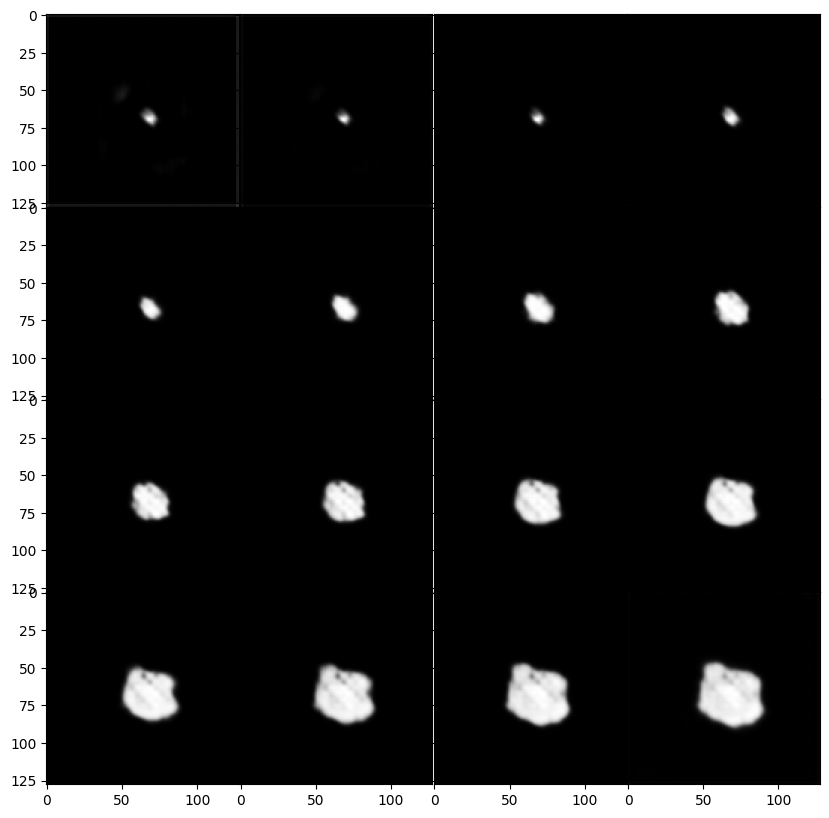

In [36]:
results = torch.squeeze(test_recon,1).cpu().numpy()
print(results.shape)
display_frames(results[4,:,:,:])
# torch.save(cae_model, "trained_cae.pt")
# model = torch.load("trained_cae.pt")
# model.eval()

In [8]:
with torch.no_grad():
    meow = model(test_norm_vids)

peak = torch.squeeze(meow,1).cpu().numpy()
print(peak.shape)
display_frames(peak[4,:,:,:])

NameError: name 'model' is not defined

Use CAE encoder output as input into LSTM to predict sequence to sequence LSTM in reduced space and use decoder to decode results in full space

Break down videos into 4 frame chunks of inputs and labels:

In [10]:
print(videos.shape)

train = videos[:-9, :, :, :]
test = videos[-9:, :, :, :]


def vid2seq(videos):
    
    in_seqs = np.ndarray(shape = (videos.shape[0]*13,4,128,128))
    out_seqs = np.ndarray(shape = (videos.shape[0]*13,4,128,128))

    for i in range(videos.shape[0]):
        for j in range (videos.shape[1]-7):
            in_seqs[i+j,:,:,:] = videos[i,j:4+j,:,:]
            out_seqs[i+j,:,:,:] = videos[i,4+j:8+j,:,:]

    return in_seqs, out_seqs

train_seqs_in, train_seqs_out = vid2seq(train)
test_seqs_in, test_seqs_out = vid2seq(test)

print(train_seqs_out.shape)
print(test_seqs_out.shape)

(49, 16, 128, 128)
(520, 4, 128, 128)
(117, 4, 128, 128)


In [11]:
class vidLSTM(nn.Module):
    def __init__(self, input_size, hidden_multiplier):
        super(vidLSTM, self).__init__()
        hidden_size = input_size // hidden_multiplier 
        output_size = input_size
        self.encoder = nn.LSTM(input_size, hidden_size)
        self.decoder = nn.LSTM(hidden_size, output_size)

    def forward(self,x):
        _, hidden, cell = self.encoder(x)
        output, _, _ = self.decoder(x, (hidden, cell))
        
        return output
    

train_seq_in_tensor = torch.unsqueeze(torch.Tensor(train_seqs_in), 1).to(device)
train_seq_out_tensor = torch.unsqueeze(torch.Tensor(train_seqs_in), 1).to(device)
test_seq_in_tensor = torch.unsqueeze(torch.Tensor(train_seqs_in), 1).to(device)
test_seq_out_tensor = torch.unsqueeze(torch.Tensor(train_seqs_in), 1).to(device)

seq_indices = torch.randperm(len(train_seq_in_tensor))
train_seq_in_tensor = train_seq_in_tensor[seq_indices]
train_seq_out_tensor = train_seq_out_tensor[seq_indices]


print(train_seq_in_tensor.shape)
cae_model.eval()
with torch.no_grad():

    train_seq_in_enc = cae_model.encoder(train_seq_in_tensor)
    train_seq_out_enc = cae_model.encoder(train_seq_out_tensor)
    test_seq_in_enc = cae_model.encoder(train_seq_out_tensor)
    test_seq_out_enc = cae_model.encoder(train_seq_out_tensor)


no_enc_features = train_seq_in_enc.shape[1]
print(no_enc_features)




torch.Size([520, 1, 4, 128, 128])
32768


In [13]:
print('Device: {0}'.format(device))

seq2seq_model = vidLSTM(10, 1)
seq2seq_model.to(device)

criterion = nn.MSELoss()
optimiser = torch.optim.Adam(seq2seq_model.parameters(), lr = 0.001)

no_epochs = 10
batch_size = 1

for epoch in range(no_epochs):
    seq2seq_model.train()
    for batch_no in range(0,len(train_seq_in_enc), batch_size):
            
            in_batch = train_seq_in_enc[batch_no:batch_no+batch_size, :]
            target_batch = train_seq_out_enc[batch_no:batch_no+batch_size, :]
            
            optimiser.zero_grad()
            next_step_pred = seq2seq_model(in_batch)
            loss = criterion(next_step_pred, target_batch)
            loss.backward()
            optimiser.step()
            

    seq2seq_model.eval()

    with torch.no_grad():
        eval_seq = seq2seq_model(test_seq_in_enc)
        loss_MSE = criterion(eval_seq,test_seq_out_enc)
        # print("Test MSE at epoch {0}: ".format(epoch+1) + str(test_loss.item()))
        loss_RMSE = torch.sqrt(loss_MSE)
        print("Test RMSE at epoch {0}: ".format(epoch+1) + str(loss_MSE.item()))





Device: cuda


c:\Users\Kishok Asus\Projects\Fire_Chimney\.venv\lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


RuntimeError: shape '[1310720, 1]' is invalid for input of size 400

#### Sources
1. Guo, Xifeng & Liu, Xinwang & Zhu, En & Yin, Jianping. (2017). Deep Clustering with Convolutional Autoencoders. 373-382. 10.1007/978-3-319-70096-0_39. 
